In [1]:
# Create kaggle account and kaggle api token kaggle.json,
# and upload that file before running this

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip dogs-vs-cats.zip

100% 810M/812M [00:05<00:00, 51.9MB/s]
100% 812M/812M [00:05<00:00, 169MB/s] 
Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [2]:
!unzip train.zip
!unzip test1.zip


Streaming output truncated to the last 5000 lines.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           

In [3]:
import os

try:
  os.makedirs('images')
except FileExistsError:
  pass

try:
  os.makedirs(os.path.join('images', 'cats'))
except FileExistsError:
  pass

try:
  os.makedirs(os.path.join('images', 'dogs'))
except FileExistsError:
  pass

In [4]:
import shutil

for filename in os.listdir('train'):
  full_path = os.path.join('train', filename)

  if filename.split('.')[0] == 'cat':
    shutil.copy(full_path, os.path.join('images', 'cats', filename))
  else:
    shutil.copy(full_path, os.path.join('images', 'dogs', filename))

In [5]:
import torch
from torch import nn
import sklearn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import pandas as pd
import numpy as npac
import matplotlib.pyplot as plt
print(torch.__version__)
torch.manual_seed(42)

2.1.0+cu118


In [6]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler

BATCH_SIZE = 32
SEED = 42
VALIDATION_SPLIT = 0.2
NUM_WORKERS = os.cpu_count()

# Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    # transforms.TrivialAugmentWide(num_magnitude_bins=31),
    # transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

# Define the dataset
full_dataset = datasets.ImageFolder(
    root='images',
    transform=data_transforms
)

# Define the random seed for data shuffling
torch.manual_seed(SEED)

# Calculate the sizes of the training and validation sets
num_samples = len(full_dataset)
num_val_samples = int(VALIDATION_SPLIT * num_samples)
num_train_samples = num_samples - num_val_samples

# Use random_split to split the dataset
train_dataset, val_dataset = random_split(full_dataset, [num_train_samples, num_val_samples])

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,  # Number of CPU cores to use for data loading (adjust as needed)
    pin_memory=True,  # Use pinned memory for faster data transfer (if available)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS ,  # Number of CPU cores to use for data loading (adjust as needed)
    pin_memory=True,  # Use pinned memory for faster data transfer (if available)
)


In [8]:
num_classes = len(train_dataset.dataset.classes)
num_classes


2

In [9]:
from torch import nn
class TinyVGG(nn.Module):

  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),

        nn.ReLU(),

        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),

        nn.ReLU(),

        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),

        nn.ReLU(),

        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),

        nn.ReLU(),

        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),

        nn.Linear(in_features = hidden_units * 13 * 13,
                  out_features = output_shape)
    )


  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)

    return x

In [10]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device = device):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()
        #  computes the gradients of the loss with respect to the model's parameters by backpropagating the error

        # 5. Optimizer step
        optimizer.step()
        # updates the model's parameters using the gradients to minimize the loss. The optimization algorithm determines how much to adjust each parameter.

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [11]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
               device=device):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [33]:

from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def pipeline(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):


  results = {"train_loss" : [],
             "train_acc" : [],
             "test_loss" : [],
             "test_acc" : []}


  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                        device=device)

    test_loss, test_acc = test_step(model = model,
                                    dataloader = test_dataloader,
                                    loss_fn = loss_fn,
                                    device=device
                                      )

    print(f"epoch: {epoch} | train loss: {train_loss: .4f} | train acc: {train_acc: .4f} | test loss: {test_loss: .4f} | test acc: {test_acc: .4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [34]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 8

model_1= TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(train_dataset.dataset.classes)).to(device)



loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(),
                             lr = 0.001)


from timeit import default_timer as timer
start_time = timer()

model_1_results = pipeline(model = model_1,
                        train_dataloader = train_loader,
                        test_dataloader = val_loader,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS,
                        device = device)
end_time = timer()

print(f"total training time: {end_time-start_time: .3f} seconds")

  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 0 | train loss:  0.6826 | train acc:  0.5544 | test loss:  0.6657 | test acc:  0.5975
epoch: 1 | train loss:  0.6277 | train acc:  0.6477 | test loss:  0.6152 | test acc:  0.6676
epoch: 2 | train loss:  0.5872 | train acc:  0.6885 | test loss:  0.5770 | test acc:  0.6969
epoch: 3 | train loss:  0.5501 | train acc:  0.7169 | test loss:  0.5579 | test acc:  0.7140
epoch: 4 | train loss:  0.5191 | train acc:  0.7429 | test loss:  0.5317 | test acc:  0.7355
epoch: 5 | train loss:  0.4917 | train acc:  0.7654 | test loss:  0.5044 | test acc:  0.7556
epoch: 6 | train loss:  0.4692 | train acc:  0.7778 | test loss:  0.5169 | test acc:  0.7502
epoch: 7 | train loss:  0.4545 | train acc:  0.7867 | test loss:  0.4815 | test acc:  0.7757
total training time:  380.714 seconds


In [55]:
custom_image_path = "/content/pitbull.jpg"
import torchvision

custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[129, 132, 129,  ...,  51,  49,  47],
         [132, 135, 132,  ...,  53,  51,  49],
         [137, 140, 137,  ...,  57,  55,  54],
         ...,
         [151, 145, 158,  ..., 159, 166, 158],
         [138, 144, 146,  ..., 144, 150, 152],
         [132, 151, 140,  ..., 131, 134, 148]],

        [[138, 141, 138,  ...,  63,  61,  59],
         [141, 144, 141,  ...,  65,  63,  61],
         [146, 149, 146,  ...,  69,  67,  66],
         ...,
         [178, 172, 185,  ..., 179, 186, 178],
         [165, 171, 173,  ..., 163, 169, 171],
         [159, 178, 167,  ..., 149, 152, 166]],

        [[145, 148, 145,  ...,  59,  57,  55],
         [148, 151, 148,  ...,  61,  59,  57],
         [153, 156, 153,  ...,  65,  63,  62],
         ...,
         [111, 105, 118,  ..., 118, 125, 117],
         [ 98, 104, 106,  ..., 107, 113, 115],
         [ 92, 111, 100,  ...,  99, 102, 116]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 127, 164])
Custom image dataty

In [56]:
## Converting to torch.float32

custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255
custom_image.dtype

torch.float32

In [57]:
## Create transform pipeline to resize image

from torchvision import transforms

custom_image_transform = transforms.Compose([transforms.Resize(size = (64,64))])

custom_image_transformed = custom_image_transform(custom_image)

custom_image_transformed.shape

torch.Size([3, 64, 64])

In [58]:
torch.manual_seed(42)

model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))



custom_image_pred, train_dataset.dataset.classes

(tensor([[-1.7082,  1.8125]], device='cuda:0'), ['cats', 'dogs'])

In [59]:
custom_image_pred_probs = torch.softmax(custom_image_pred, dim = 1)
custom_image_pred_probs

tensor([[0.0287, 0.9713]], device='cuda:0')

In [60]:
custom_image_pred_labels = torch.argmax(custom_image_pred_probs, dim =1).cpu()
custom_image_pred_labels

tensor([1])

In [61]:
class_names = train_dataset.dataset.classes

In [62]:
class_names[custom_image_pred_labels]

'dogs'

In [63]:
from typing import Tuple, Dict, List

def pred_and_plot_image(model: torch.nn.Module,image_path: str,
                        class_names: List[str] = None,
                        transform = None, device = device):

  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  target_image = target_image / 255

  if transform:
    target_image = transform(target_image)

  model.to(device)

  model.eval()
  with torch.inference_mode():
    target_image = target_image.unsqueeze(0)

    target_image_pred = model(target_image.to(device))

  target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)

  target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)

  plt.imshow(target_image.squeeze().permute(1,2,0))

  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"

  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"

  plt.title(title)
  plt.axis(False)


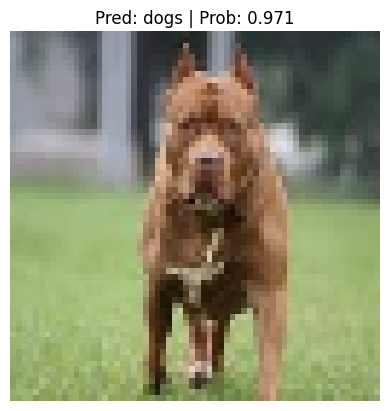

In [64]:
pred_and_plot_image(model = model_1,
                    image_path = custom_image_path,
                    class_names = class_names,
                    transform = custom_image_transform,
                    device = device)